# Calculate the monthly means of errors in QDM predictions
- QDM: Quantile Delta Mapping
- QDM(Q_initial) = Q_initial + delta_Q ; delta_Q = Q_final - Q_initial 
- QDM error  = QDM(Q_initial) - Q_final
- If we apply Quantile Delta Mapping to model delta with the delta_Q also coming from the same model we expect QDM error =0
- In this notebook, Q_inital is the pre-industrial quantile function and Q_final is the End of 21st century quantile function
- These quantile functions are constructed from detrended CESM2 LENS data
- In this notebook, we compute the monthly mean of the QDM error to check if it is identically zero

In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
import matplotlib.pyplot as plt
import matplotlib as mtplt
import glob
# import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#np.set_printoptions(threshold=np.inf)
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from datetime import datetime, timedelta
import pandas as pd
import random

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.23.0,>=1.16.5'), {'scipy'}))'.
  numba.core.entrypoints.init_all()
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.2

In [14]:
chic_lat  = 41.8781
chic_lon  = (360-87.6298)%360
ben_lat   = 12.9716
ben_lon   = 77.5946
#########
locn   = 'chicago'
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
cesm2_path        = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals             = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
cmip6_cvals       = cvals + 'cmip6/'
#cvals_det     = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
############
pi_year  = 1865
eoc_year = 2085
#
doy  = 211
season     = 'DJF'
season0    = 'djf'
months     = [12,1,2]
#
pi_year0  = '1850'
pi_year1  = '1879'
ic_year0  = '2071'
ic_year1  = '2100'

In [3]:
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B %d')
###############################
date = no_leap_date(doy)
date

'July 30'

In [4]:
def to_daily(ds):
    year       = ds.time.dt.year
    dayofyear  = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), dayofyear=("time", dayofyear.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "dayofyear")).unstack("time")  

def stacker(x,stackdim_name):
    #Assumes that x has dimensions year and member
    #x = x.stack(stackdim_name=('year','member'),create_index=False)
    x = x.stack({stackdim_name: ('year', 'member')},create_index=False)
    return x

def stack_roll(ds,roll_len,stride_len,stackdim_name):
    #Assumes that ds has dimensions year and member
    ds_stack   = stacker(ds,stackdim_name)
    #print(ds_stack)
    ds_roll    = ds_stack.rolling({stackdim_name:roll_len}, center=True).construct('index', stride=stride_len)
    
    return ds_roll

In [5]:
# calculate global means
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'quantile','model_id','obs_id'}
    return (ds * weight).mean(other_dims)

In [6]:
def implement_mdm(ds_obs,init_mean,final_mean,init_std,final_std):
    # Assuming coordinates year and day for ds_obs
    obs_mean = ds_obs.mean('year')
    sratio   = final_std/init_std
    ds_mdm   = obs_mean + (final_mean - init_mean) + sratio*(ds_obs - obs_mean)        
    return ds_mdm

def implement_qdm(qobs, qinit, qfinal):
    # Implement quantile delta mapping. Assumes model data has corrd called 'mtime'
    #qinit    = init_data.quantile(quants,dim='mtime')
    #qfinal   = final_data.quantile(quants,dim='mtime')
    ds_qdm   = qobs + (qfinal - qinit)
    return ds_qdm

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

#
quants = np.linspace(0,1.0,30)
def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

In [7]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=condo_cumulus_lr6','--account=lr_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='5:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(2)

In [8]:
cluster

SLURMCluster(1215f643, 'tcp://10.0.39.4:41195', workers=0, threads=0, memory=0 B)

## Compute QDM errors

### Load detrended CESM2 data

In [25]:
%%time
pi_det  = xr.open_zarr(cvals+'pi_detrended.zarr').detrended_tmax
eoc_det = xr.open_zarr(cvals+'eoc_detrended.zarr').detrended_tmax
#
# Select data corresponding to seasons
pi_jan  = pi_model_det.where( (pi_det['dayofyear'] <= 31), drop=True)
eoc_jan = eoc_model_det.where((eoc_det['dayofyear'] <= 31), drop=True)
pi_jan   = pi_jan.chunk({'dayofyear':10,'lon':5})
eoc_jan  = eoc_jan.chunk({'dayofyear':10,'lon':5})

CPU times: user 3.43 s, sys: 439 ms, total: 3.87 s
Wall time: 3.95 s


In [40]:
N_mem       = 100 
window_len  = 30
#### Stack and apply rolling window #######
pi_jan_roll   = stack_roll(pi_jan,N_mem*window_len,N_mem,stackdim_name='mtime')
eoc_jan_roll  = stack_roll(eoc_jan,N_mem*window_len,N_mem,stackdim_name='mtime')
#
pi_jan_roll0  = pi_jan_roll.sel(mtime  = [15])
eoc_jan_roll0 = eoc_jan_roll.sel(mtime = [15])
#
# pi_jan_roll0 

In [39]:
# Add mtime as a coordinate 
pi_jan_roll1 =  pi_jan_roll0.assign_coords(mtime=('mtime',[pi_year]))
eoc_jan_roll1 = eoc_jan_roll0.assign_coords(mtime=('mtime',[eoc_year]))
eoc_jan_roll1

<xarray.DataArray 'detrended_tmax' (lat: 192, lon: 288, dayofyear: 31,
                                    mtime: 1, index: 3000)>
dask.array<getitem, shape=(192, 288, 31, 1, 3000), dtype=float64, chunksize=(8, 5, 10, 1, 3000), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31
    degree     int64 1
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member     (mtime) int64 0
    year       (mtime) int64 2086
  * mtime      (mtime) int64 2086
Dimensions without coordinates: index

In [42]:
%%time
# Save detrended data 
pi_detroll_path  = cvals+ 'pi_detrended_roll_jan'+'_'+pi_year0+'_'+pi_year1+'.zarr'
eoc_detroll_path = cvals+ 'eoc_detrended_roll_jan'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#
print(pi_detroll_path )
# pi_jan_roll1.to_dataset().to_zarr(pi_detroll_path, mode ='w')

/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/pi_detrended_roll_jan_1850_1879.zarr


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 19.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 20min 41s, sys: 46.3 s, total: 21min 27s
Wall time: 22min 21s


In [43]:
%%time
# eoc_jan_roll1.to_dataset().to_zarr(eoc_detroll_path, mode ='w')

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 17.36 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 19min 3s, sys: 40 s, total: 19min 43s
Wall time: 20min 32s


In [12]:
######################

## Perform Quantile Delta Mapping

In [20]:
qpi_model  = compute_quantiles(pi_model)
qeoc_model = compute_quantiles(eoc_model)
#
qpi_obs  = compute_quantiles(pi_obs)
qeoc_obs = compute_quantiles(eoc_obs)
#
qano     = qeoc_model - qpi_model

In [21]:
qpi_qdm =  qpi_obs + qano
# qpi_qdm = qpi_qdm.chunk({'obs_id':-1})
qpi_qdm = qpi_qdm.chunk({'obs_id':1})
qpi_qdm

<xarray.DataArray 'TREFHTMX' (quantile: 30, lat: 192, lon: 288, obs_id: 10,
                              dayofyear: 365, model_id: 10)>
dask.array<rechunk-merge, shape=(30, 192, 288, 10, 365, 10), dtype=float64, chunksize=(30, 8, 60, 1, 73, 10), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * obs_id     (obs_id) int64 16 94 76 13 83 61 6 5 0 99
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0
  * model_id   (model_id) int64 82 15 4 95 36 32 29 18 99 0

## MDM vs QDM

## Select model and observations and plot

In [24]:
model_index = 0
obs_index   = 0

In [25]:
%%time
#
qpi_mdm_day    = qpi_mdm.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest')\
                  .sel(model_id = model_index).sel(obs_id = obs_index)
#
qpi_qdm_day    = qpi_qdm.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest')\
                    .sel(model_id = model_index).sel(obs_id = obs_index)

CPU times: user 55.4 ms, sys: 12.3 ms, total: 67.7 ms
Wall time: 62.7 ms


In [26]:
qpi_sqdm  = xr.apply_ufunc(
    np.sort,
    qpi_qdm,
    input_core_dims=[['quantile']],
    output_core_dims=[['quantile']],
    dask='parallelized'
)
# qpi_sqdm

In [27]:
qpi_sqdm_day = qpi_sqdm.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest')\
                .sel(model_id = model_index).sel(obs_id = obs_index)

In [28]:
# qeoc_model_day = qeoc_model.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(model_id =model_index)
#
qpi_model_day  = qpi_model.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(model_id =model_index)
#
qpi_obs_day    = qpi_obs.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(obs_id =obs_index)
#
qeoc_obs_day   = qeoc_obs.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(obs_id =obs_index)

CPU times: user 42.1 s, sys: 1.99 s, total: 44.1 s
Wall time: 1min 46s


Text(0.05, 0.95, 'obs_index = 99\nmodel_index = 1')

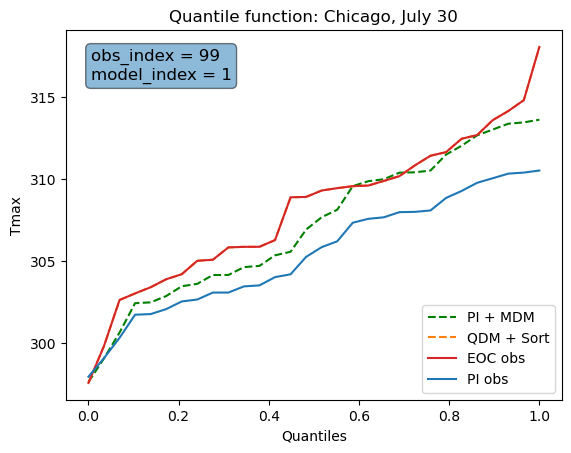

In [29]:
%%time
#
model_index = 1
obs_index   = 99
#
text_str = f'obs_index = {obs_index}\nmodel_index = {model_index}'  # Construct the text string with line breaks
#
plt.plot(quants,qpi_mdm_day,'--',color='green',label='PI + MDM')
plt.plot(quants,qpi_sqdm_day,'--',color='tab:orange',label='QDM + Sort')
plt.plot(quants,qeoc_obs_day,color='tab:red',label ='EOC obs')
plt.plot(quants,qpi_obs_day,color= 'tab:blue', label ='PI obs')
#
plt.xlabel('Quantiles')
plt.ylabel('Tmax')
plt.legend(loc='lower right')
plt.title('Quantile function: Chicago, ' + date)
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12, \
         verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))

- Test if model_index and obs_index are same, rmse for Sorted QDM should be zero

In [39]:
# rmse_sqdm_day.values

### Compute global mean of absolute error 
- Quantile function after applying mdm on model pre-ind quantile function is denoted qpi_mdm using some qeoc_obs
- `Observed' end-of-21st-century quantile function is qeoc_obs
- Therefore, error for a give model and obs pair is defined as qpi_mdm - qeoc_obs. 
- Here, qeoc_obs0 is used instead of qeoc_obs to implement this computation using xarray broadcasting
- We then take the absolute value of this quantitiy and compute global mean

In [40]:
mdm_abserr = np.fabs(qeoc_obs - qpi_mdm)
mdm_abserr 

<xarray.DataArray (quantile: 30, lat: 192, lon: 288, obs_id: 10,
                   dayofyear: 365, model_id: 10)>
dask.array<fabs, shape=(30, 192, 288, 10, 365, 10), dtype=float64, chunksize=(30, 8, 60, 1, 73, 10), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * obs_id     (obs_id) int64 16 94 76 13 83 61 6 5 0 99
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0
  * model_id   (model_id) int64 82 15 4 95 36 32 29 18 99 0

In [41]:
# Mean absolute Error, where mean is global and annual mean
mdm_mae = global_mean(mdm_abserr)
mdm_mae

<xarray.DataArray (quantile: 30, obs_id: 10, model_id: 10)>
dask.array<mean_agg-aggregate, shape=(30, 10, 10), dtype=float64, chunksize=(30, 1, 10), chunktype=numpy.ndarray>
Coordinates:
  * obs_id    (obs_id) int64 16 94 76 13 83 61 6 5 0 99
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0
  * model_id  (model_id) int64 82 15 4 95 36 32 29 18 99 0

In [42]:
%%time
# # mdm_mae.rename('tmax').to_dataset().to_zarr(cvals+'mdm_mae_27examples.zarr',mode='w')
# mdm_mae.rename('tmax').to_dataset().to_zarr(cvals+'mdm_mae_216examples.zarr',mode='w')
# mdm_mae.rename('tmax').to_dataset().to_zarr(cvals+'mdm_mae_100examples.zarr',mode='w')

CPU times: user 14 µs, sys: 1 µs, total: 15 µs
Wall time: 28.4 µs


In [43]:
# mdm_mae = xr.open_zarr(cvals+'mdm_mae_27examples.zarr').tmax
# mdm_mae = xr.open_zarr(cvals+'mdm_mae_216examples.zarr').tmax
mdm_mae = xr.open_zarr(cvals+'mdm_mae_100examples.zarr').tmax

Text(0.5, 0, 'Percentiles')

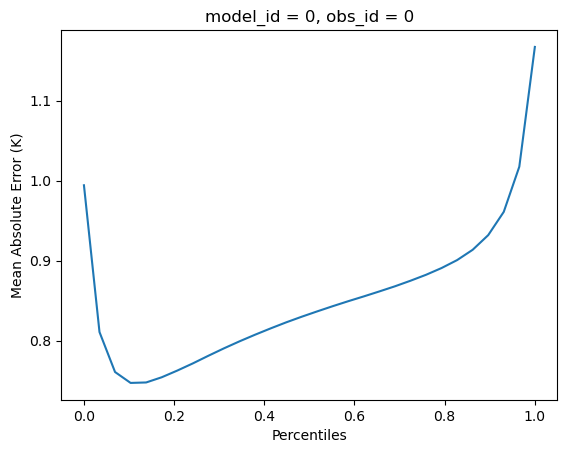

In [44]:
mdm_mae.sel(model_id=0,obs_id=0).plot()
plt.ylabel('Mean Absolute Error (K)')
plt.xlabel('Percentiles')

Text(0.5, 0, 'Percentiles')

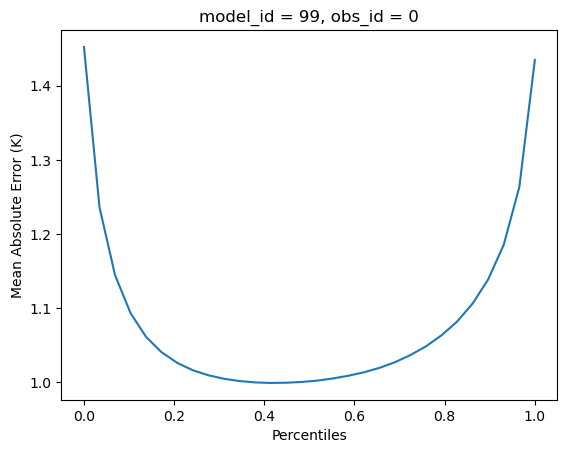

In [45]:
mdm_mae.sel(model_id=99,obs_id=0).plot()
plt.ylabel('Mean Absolute Error (K)')
plt.xlabel('Percentiles')

In [46]:
mdm_mae.sel(model_id=99,obs_id=99).values

array([1.02598436, 0.8380084 , 0.78537408, 0.76926906, 0.76651676,
       0.76976936, 0.77550813, 0.78203248, 0.78889299, 0.79544743,
       0.80195976, 0.80848186, 0.81484332, 0.82132372, 0.82777278,
       0.83446472, 0.84046521, 0.84608348, 0.851807  , 0.85734977,
       0.86272338, 0.8682256 , 0.87343223, 0.87852824, 0.88467788,
       0.89373015, 0.90906753, 0.93694997, 0.99464989, 1.14997224])

### Calculate Mean Absolute Error for sorted QDM

In [47]:
sqdm_abserr = np.fabs(qeoc_obs - qpi_sqdm)
sqdm_mae = global_mean(sqdm_abserr)

In [48]:
%%time
# # sqdm_mae.rename('tmax').to_dataset().to_zarr(cvals+'sqdm_mae_27examples.zarr',mode='w')
# sqdm_mae.rename('tmax').to_dataset().to_zarr(cvals+'sqdm_mae_216examples.zarr',mode='w')
# sqdm_mae.rename('tmax').to_dataset().to_zarr(cvals+'sqdm_mae_100examples.zarr',mode='w')

CPU times: user 13 µs, sys: 1 µs, total: 14 µs
Wall time: 26.7 µs


CPU times: user 536 ms, sys: 63.5 ms, total: 599 ms
Wall time: 620 ms


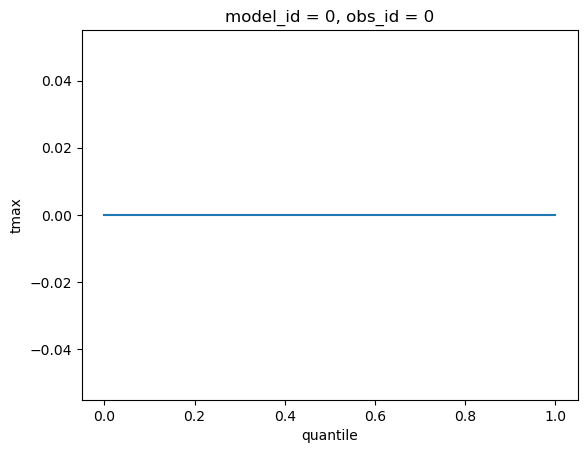

In [49]:
%%time
# sqdm_mae = xr.open_zarr(cvals+'sqdm_mae_27examples.zarr').tmax
# sqdm_mae = xr.open_zarr(cvals+'sqdm_mae_216examples.zarr').tmax
sqdm_mae = xr.open_zarr(cvals+'sqdm_mae_100examples.zarr').tmax
sqdm_mae.sel(model_id=0,obs_id=0).plot()

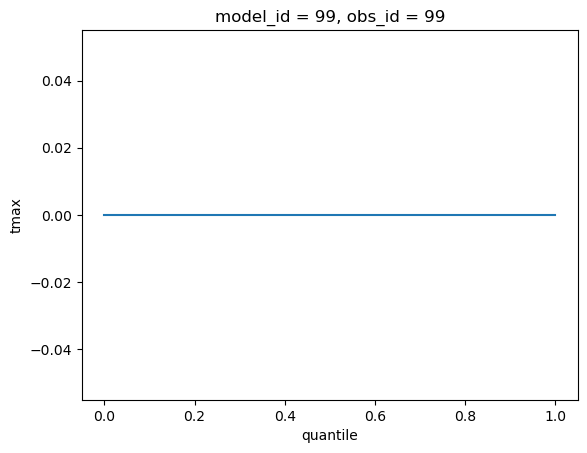

In [50]:
sqdm_mae.sel(model_id=99,obs_id=99).plot()

## Calculate mean of mean absolute error over (obs_id,model_id) pairs 
 - Recall that MAE for a given (obs,model) pair is computed as a global mean and mean overy days of the year.

In [51]:
%%time
mdm_mae_flattened  = mdm_mae.stack(pairs=('obs_id','model_id'),create_index=False)
sqdm_mae_flattened = sqdm_mae.stack(pairs=('obs_id','model_id'),create_index=False)
mdm_mae_flattened

CPU times: user 12.6 ms, sys: 2.98 ms, total: 15.6 ms
Wall time: 13.5 ms


<xarray.DataArray 'tmax' (quantile: 30, pairs: 100)>
dask.array<reshape, shape=(30, 100), dtype=float64, chunksize=(30, 10), chunktype=numpy.ndarray>
Coordinates:
    model_id  (pairs) int64 82 15 4 95 36 32 29 18 99 ... 4 95 36 32 29 18 99 0
    obs_id    (pairs) int64 16 16 16 16 16 16 16 16 ... 99 99 99 99 99 99 99 99
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0
Dimensions without coordinates: pairs

In [52]:
average_mdm_mae  = mdm_mae_flattened.mean('pairs')
average_sqdm_mae = sqdm_mae_flattened.mean('pairs')

In [53]:
%%time
# average_mdm_mae.to_dataset().to_zarr(cvals + 'mdm_mae_avg36pairs.zarr',mode='w')
# average_sqdm_mae.to_dataset().to_zarr(cvals + 'sqdm_mae_avg36pairs.zarr',mode='w')
average_mdm_mae.to_dataset().to_zarr(cvals + 'mdm_mae_avg100pairs.zarr',mode='w')
average_sqdm_mae.to_dataset().to_zarr(cvals + 'sqdm_mae_avg100pairs.zarr',mode='w')

CPU times: user 1.33 s, sys: 192 ms, total: 1.53 s
Wall time: 1.9 s


In [54]:
# average_mdm_mae  = xr.open_zarr(cvals + 'mdm_mae_avg36pairs.zarr').tmax
# average_sqdm_mae = xr.open_zarr(cvals + 'sqdm_mae_avg36pairs.zarr').tmax
average_mdm_mae  = xr.open_zarr(cvals + 'mdm_mae_avg100pairs.zarr').tmax
average_sqdm_mae = xr.open_zarr(cvals + 'sqdm_mae_avg100pairs.zarr').tmax

In [55]:
%%time
qano_std_agmean = xr.open_zarr(cvals+'cmip6_quantiles_ano_agmean.zarr').tasmax_qanomaly
qano_std_agmean

CPU times: user 23 ms, sys: 3.88 ms, total: 26.9 ms
Wall time: 23.5 ms


<xarray.DataArray 'tasmax_qanomaly' (quantile: 30)>
dask.array<open_dataset-4a01f5a189a1fb0ceab2761a3dbe950etasmax_qanomaly, shape=(30,), dtype=float64, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0

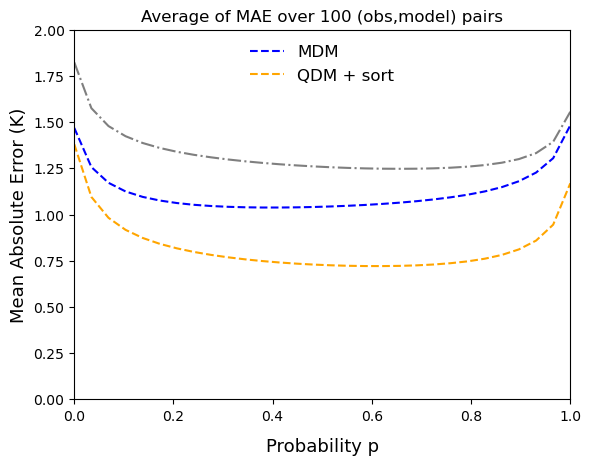

CPU times: user 1.8 s, sys: 104 ms, total: 1.9 s
Wall time: 1.89 s


In [56]:
%%time
quants30        = np.linspace(0,1.0,30)
plt.plot(quants30,average_mdm_mae,'--',label='MDM',color = 'blue')
plt.plot(quants30,average_sqdm_mae,'--',label='QDM + sort',color = 'orange')
plt.plot(quants30,qano_std_agmean,'-.',color='tab:gray',markersize=4)
plt.legend(loc='upper center',prop={'size':12},frameon=False)
#
plt.title('Average of MAE over 100 (obs,model) pairs')
plt.ylabel('Mean Absolute Error (K)',fontsize=13)
plt.xlabel('Probability p',fontsize=13,labelpad=10)
plt.xlim(0.0,1.0)
plt.ylim(0.0,2.0)
plt.show()

## Check the sorting function

In [57]:
is_sorted(qpi_sqdm_day.values)

True

In [58]:
is_sorted(qpi_mdm_day.values)

True

In [59]:
%%time
xs.rmse(qeoc_obs_day,qpi_mdm_day).values

CPU times: user 25.4 s, sys: 1.27 s, total: 26.7 s
Wall time: 1min 3s


array(1.41472087)

In [60]:
%%time
xs.rmse(qeoc_obs_day,qpi_qdm_day).values

CPU times: user 25.2 s, sys: 1.26 s, total: 26.4 s
Wall time: 1min 2s


array(0.)